# 1. Predictive Default Risk Modeling for Smarter Loan Approvals

**Summary:**  
Build a regularized logistic regression model on 45 000 historical loan applications to estimate each applicant’s probability of default.  

**Key Features:**  
- **Demographics:** age, gender, education  
- **Financial Profile:** income, employment tenure, home‐ownership  
- **Credit History:** credit score, length of credit history, past defaults  
- **Loan Details:** amount, purpose, interest rate, payment‑to‑income ratio  

**Objective:**  
- **Balance** catching true defaulters (recall) against avoiding false alarms on good borrowers (precision)  
- **Optimize** the F₁‑Score on the “default” class as our primary metric  

**Business Impact:**  
- Reduce credit losses by flagging high‑risk applicants  
- Accelerate approvals for low‑risk borrowers  
- Inform data‑driven underwriting thresholds and loan‐term adjustments via `.predict_proba()`  


# 2. Data loading and Inspection

In [1]:
#import the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#import sklearn libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (FunctionTransformer, OneHotEncoder, OrdinalEncoder, StandardScaler)


#folder manager

import os


In [31]:
loan_df = pd.read_csv('data/loan_data.csv')
loan_df.head(5)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [3]:
loan_df.shape

(45000, 14)

There are `45,000` rows and `14` columns in the data.

#### Check for missing values

In [4]:
loan_df.isnull().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

#### Check data types

In [5]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

### loan_df info interpretation and expectation

| Column Name                         | Current Type      | To be converted to| Reason                                                          |
| ----------------------------------- | ----------------- | ----------------- | --------------------------------------------------------------- |
| `person_gender`                     | `object`          | `category`        | Categorical variable with limited values ("male", "female")     |
| `person_education`                  | `object`          | `category`        | label encoding variable ("High School", "Bachelor", etc.)      |
| `person_home_ownership`             | `object`          | `category`        | Nominal categories like "RENT", "OWN", "MORTGAGE"               |
| `loan_intent`                       | `object`          | `category`        | Nominal loan purpose categories ("EDUCATION", "PERSONAL", etc.) |
| `previous_loan_defaults_on_file`    | `object`          | `binary/int`      | Convert `"Yes"` : `1`, `"No"` :`0` for modeling                |
| `loan_status`                       | `int64`           | `Already correct` | Target column (binary: 0/1)                                     |
| `person_age`, `person_income`, etc. | `Already numeric` | -                 | No changes needed                                               |


#### Data statistics: To get a glimpse into data distribution

In [6]:
loan_df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


### loan_df.describe interpretation

The dataset has 45,000 loan applications. Below are the observation that will be noted during analysis.

`person_age`: The average age of applicant is around 28 nyears, with most people falling between 24 and 30 i.e 75% of the distribution. 

`person_income`: The minimum income is about 8000, average income is 80319.05 and the maxium income is over 7 million.

`person_emp_exp`: On average, applicants have about 5 years of employment experience. However, the maximum value is `125 years`, which is likely an error. This field would be inspected and cleaned accordingly.

`Loan Amount`: The loan amounts range from 500 to 35,000, with a median of $8,000. These values appear reasonable.

`loan_int_rate` : The loan interest rates vary between 5.4% "min value" and 20%,"max value" with a median around 11%.

`credit_score` : This falls within the standard credit score range i.e 300 - 850

In [7]:
# To check for class imbalance
loan_df['loan_status'].value_counts(normalize = True)

loan_status
0    0.777778
1    0.222222
Name: proportion, dtype: float64

#### Class Balance:

`77.8%` of loans were defaulted (status 0)

`22.2%` of loans repaid (status 1)



In [8]:
#check for duplicates

loan_df.duplicated().sum()

0

# 3. Visualization

In [10]:
#creating a folder for visualization
folder_name = 'graphs'
try:
    os.mkdir(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
except FileExistsError:
    # This block runs if the folder already exists
    print(f"Folder '{folder_name}' already exist.")
except Exception as e:
    # Catches any other unexpected errors
    print("An unexpected error occurred:", e)

Folder 'graphs' already exist.


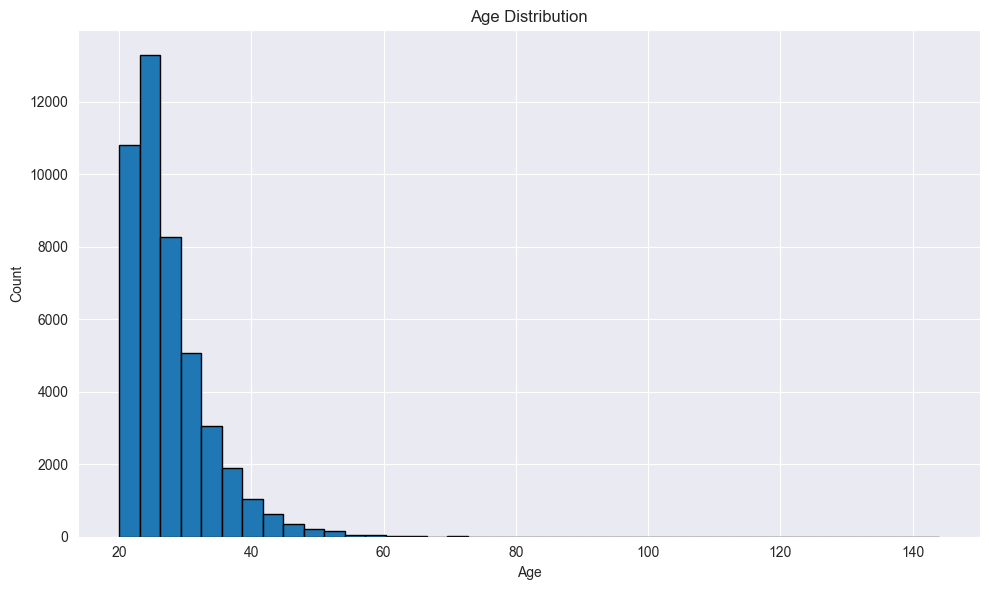

In [11]:
# Histograph for Age

sns.set_style("darkgrid")

plt.figure(figsize=(10, 6))
plt.hist(loan_df['person_age'], bins= 40, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()

#save plot
plt.savefig("graphs/age_hist.png")
plt.show()


### Age Distribution Interpretation

- The histogram shows that the majority of applicants are clustered between about 20 and 35 years old, with a clear peak in the mid‑20s.  
- There is a right tail extending into older ages, but very few applicants above 60, this appear as isolated bars.  
- This suggests the core borrower base is young, and only occasional outliers (e.g. retirees or very senior professionals) apply for these loans.

In [12]:
loan_df['person_gender'].value_counts(normalize = True)

person_gender
male      0.552022
female    0.447978
Name: proportion, dtype: float64

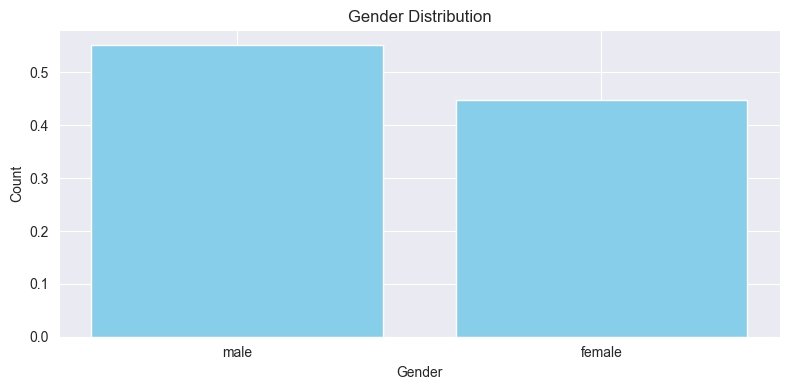

In [13]:
# bar chart for gender

sns.set_style("darkgrid")

# compute counts
gender_counts = loan_df['person_gender'].value_counts(normalize = True)

plt.figure(figsize=(8, 4))
plt.bar(gender_counts.index, gender_counts.values, color = 'skyblue')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.tight_layout()

#save plot
plt.savefig("graphs/gender_bar.png")
plt.show()


### Gender Distribution

- The applicant pool is composed of approximately 25 000 males and 20 000 females.  
- Males represent roughly 55% of all applicants, while females account for about 45%.  

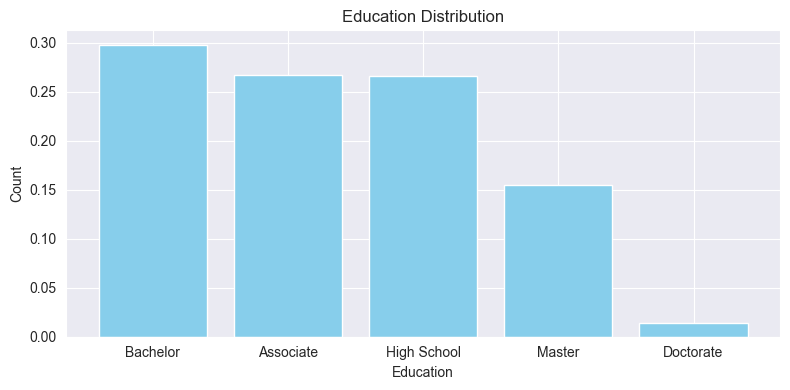

In [14]:
# education barchart

edu_count = loan_df['person_education'].value_counts(normalize = True)

plt.figure(figsize=(8, 4))
plt.bar(edu_count.index, edu_count.values, color = 'skyblue')
plt.title('Education Distribution')
plt.xlabel('Education')
plt.ylabel('Count')
plt.tight_layout()

#save plot
plt.savefig("graphs/education_bar.png")
plt.show()

### Education Distribution Interpretation

- **Bachelor’s degree** is the most common, comprising nearly 30% of applicants.  
- **Associate** and **High School** diplomas are close behind at around 27% each, indicating a sizable share of mid‑level qualifications.  
- **Master’s degree** holders account for roughly 15% of the pool—strong representation but noticeably fewer than bachelor’s-level applicants.  
- **Doctorate** degrees are very rare (around 1–2%), likely reflecting that borrowers with PhDs are a small minority.

Overall, the borrower education profile shows that most borrowers have completed somewhere between two and four years of education i.e Bachelor and associate.

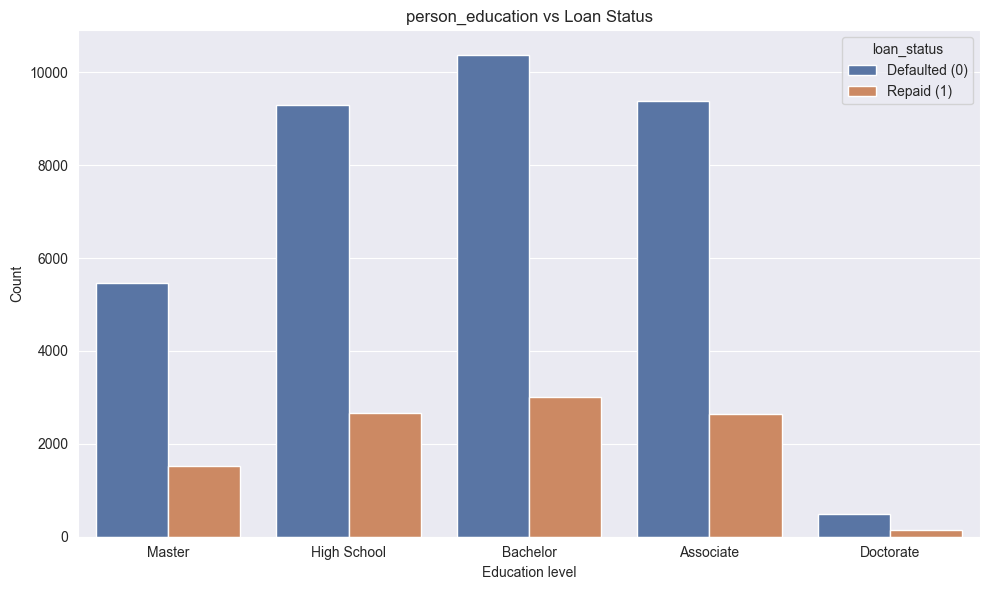

In [15]:
# Educaion vs loan status

status_palette = {0: '#4C72B0', 1: '#DD8452'}

plt.figure(figsize=(10, 6))
sns.countplot(
    x='person_education',
    hue='loan_status',
    data=loan_df,
    palette=status_palette,
    order=['Master', 'High School', 'Bachelor', 'Associate', 'Doctorate']
)
plt.title('person_education vs Loan Status')
plt.xlabel('Education level')
plt.ylabel('Count')
plt.legend(title='loan_status', labels=['Defaulted (0)', 'Repaid (1)'])
plt.tight_layout()

# Save and show
plt.savefig("graphs/education_vs_status_bar.png")
plt.show()

In [15]:
# Calculate default rate by education level
repayment_rates = (
    loan_df
    .groupby('person_education')['loan_status']
    .mean()  
    .sort_values(ascending=False))

# Convert to percentage
default_rates_percent = round((1 - repayment_rates) * 100, 2)
print("Default Rate by Education Level (%):")
print(default_rates_percent)

Default Rate by Education Level (%):
person_education
Doctorate      77.13
Bachelor       77.48
High School    77.69
Associate      77.97
Master         78.24
Name: loan_status, dtype: float64


### Education Level vs. Loan Repayment plot

- **Absolute Counts:**  
  - **Bachelor’s** degree holders are the largest group, with over 10000 defaulted and about 3 000 repaid loans.  
  - **High School** graduates follow closely ( about 9000 defaulted  and over 2000 repaid).  
  - **Associate** and **Master’s** degree groups each show over 9000 and over 5000 defaulted loans respectively, with repaid around over 2500 and about 1500.  
  - **Doctorate** holders are fewest (approx 500 defaluted, approx 120 repaid).

### Default Rate by Education Level

| Education Level | Default Rate (%) |
|-----------------|------------------|
| Doctorate       | 77.13            |
| Bachelor        | 77.48            |
| High School     | 77.69            |
| Associate       | 77.97            |
| Master          | 78.24            |

**Key Takeaways:**
    - **Master** holders show the highest default rate (78.24%), followed by **Associate** with (77.97 %) default rate. **High school** with (77.69%), **Bachelor** with (77.48%) and **Doctorate** with 77.13% default rate

#### To do
    - Given these subtle differences, encoding `person_education` in the model (e.g., as one-hot variables) should help capture impacts on default risk without overemphasizing education level.  

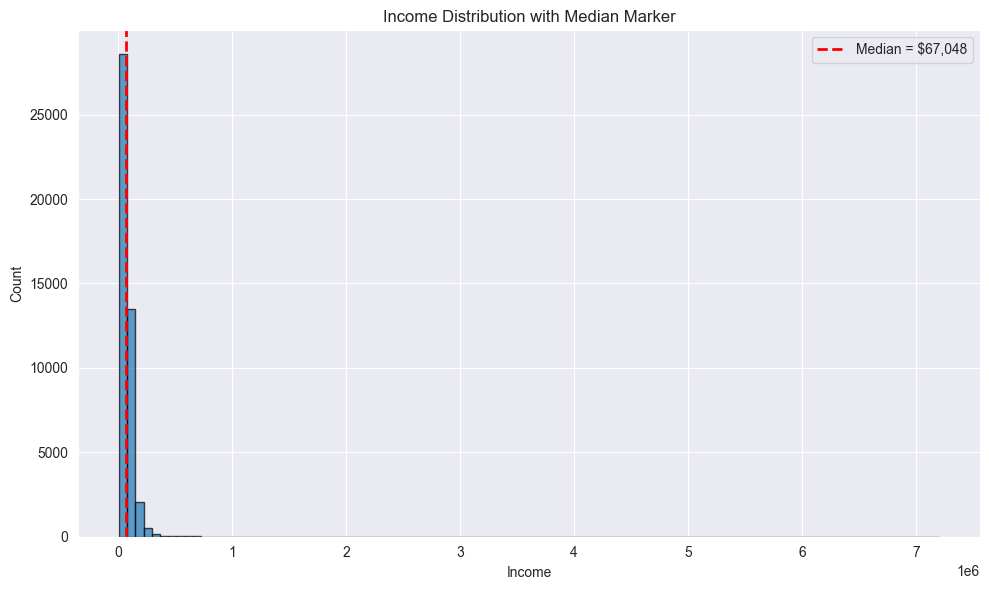

In [19]:
# Histograph for Income

#show the median income
median_income = loan_df['person_income'].median()

plt.figure(figsize=(10, 6))
plt.hist(loan_df['person_income'], bins=100, edgecolor='black', alpha=0.7)
plt.axvline(median_income, color='red', linestyle='--', linewidth=2, label=f'Median = ${median_income:,.0f}')
plt.title('Income Distribution with Median Marker')
plt.xlabel('Income')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()

#save plot
plt.savefig("graphs/income_hist.png")
plt.show()


## Income Distribution – Next Steps & Expectations

- **Current View:**  
  Even with 100 bins nearly everyone falls into the first bin.

- **Expectation for Later Analysis:**  
  - **Correlation check:** We’ll assess how `person_income` correlates with `loan_status` (e.g. via violin plots) to verify if higher incomes indeed correspond to lower default rates.

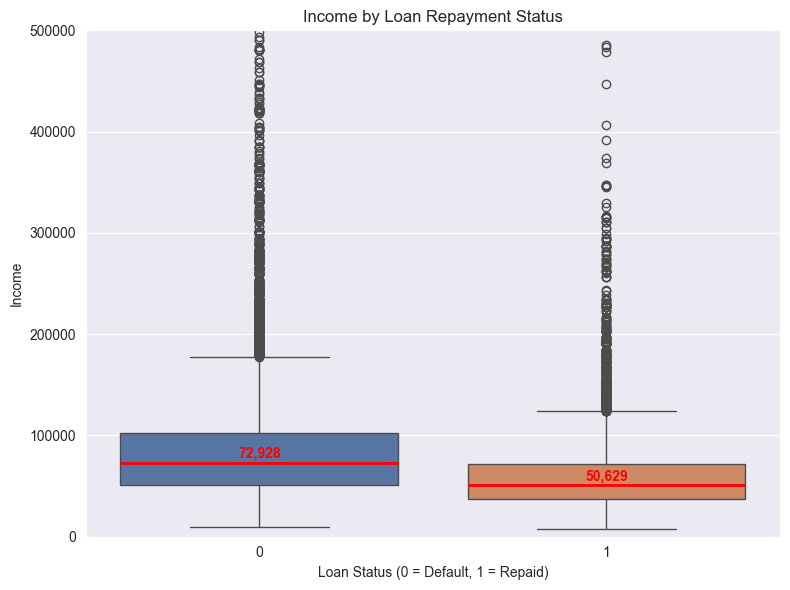

In [17]:
#income by loan repayment 
# calucualte medians
medians = loan_df.groupby('loan_status')['person_income'].median()

plt.figure(figsize=(8, 6))
sns.boxplot(
    x='loan_status',
    y='person_income',
    hue='loan_status', 
    data=loan_df,
    palette={0: '#4C72B0', 1: '#DD8452'},
    medianprops={'color': 'red', 'linewidth': 2},
    dodge=False)

plt.legend([], [], frameon=False)

# zoom in to the plot to make median line visible
plt.ylim(0, 500_000)

# Annotate the median values
for status, median in medians.items():
    plt.text(status, median + 5000, f'{median:,.0f}',
             ha='center', color='red', weight='bold')

# Labels and title
plt.title('Income by Loan Repayment Status')
plt.xlabel('Loan Status (0 = Default, 1 = Repaid)')
plt.ylabel('Income')

plt.tight_layout()

# Save & show
plt.savefig("graphs/incomeby_status.png")
plt.show()


### Why plot income by loan repayment status?
By splitting income into two boxplot. one for borrowers who repaid (status 1) and one for those who defaulted (status 0), we directly compare their earning patterns. This helps us to:

1. Spot differences in median that might signal risk.

2. Decide how to treat income in our model (e.g. transform, cap outliers, or bin into ranges).

3. Validate generic assumptions like lower‑income borrowers default more often compared to high income earners.: Howeg

### Income by Loan Repayment Status plot interpretataion
- **Median Incomes:**  
  - **Repaid (1):**  \$50,629 
  - **Defaulted (0):** \$72,928
  The red lines and labels show that borrowers who eventually default tend to have a slightly higher median income than those who repay.

- **Outliers:**  
  - Both groups include high‑income outliers represented by the circles in the plot.  

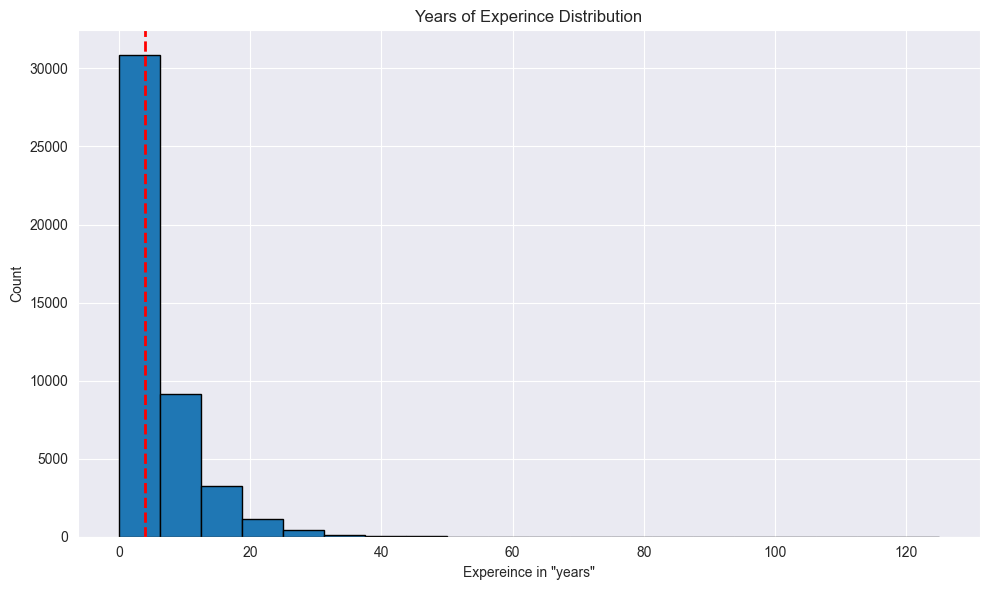

In [17]:
# Histograph for Age

median_exp = loan_df['person_emp_exp'].median()

plt.figure(figsize=(10, 6))
plt.hist(loan_df['person_emp_exp'], bins= 20, edgecolor='black')
plt.axvline(median_exp, color='red', linestyle='--', linewidth=2, label=f'Median = ${median_income:,.0f}')
plt.title('Years of Experince Distribution')
plt.xlabel('Expereince in "years"')
plt.ylabel('Count')
plt.tight_layout()

#save plot
plt.savefig("graphs/exprience.png")
plt.show()


### Years of Employment Experience Distribution (with Median Marker)

- The **red dashed line** marks the median experience, which sits at around **3 years**, indicating half of applicants have under 3 years on the job.  
- The distribution is **right‑skewed**:  
  - **0–5 years** covers the vast majority of borrowers.  
  - There’s a long tail of very tenured applicants (20+ years), but they are rare.

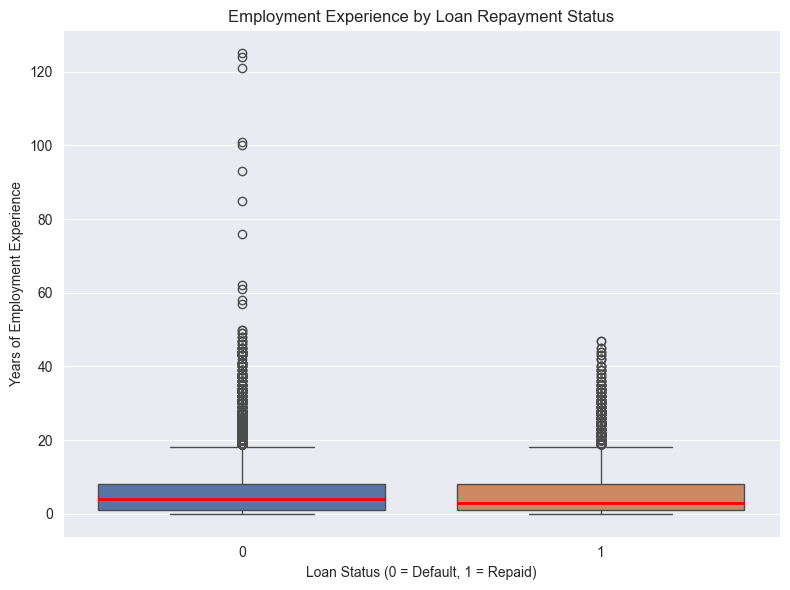

In [18]:
# Employment Experience by Loan Repayment Status

plt.figure(figsize=(8, 6))
sns.boxplot(
    x='loan_status',
    y='person_emp_exp',
    hue='loan_status',          
    data=loan_df,
    palette={0: '#4C72B0', 1: '#DD8452'},
    dodge=False,                
    medianprops={'color': 'red', 'linewidth': 2}
)
plt.legend([], [], frameon=False)  
plt.title('Employment Experience by Loan Repayment Status')
plt.xlabel('Loan Status (0 = Default, 1 = Repaid)')
plt.ylabel('Years of Employment Experience')
plt.tight_layout()
plt.savefig("graphs/experience_by_status_boxplot.png")
plt.show()


### Why Employment Experience by Loan Repayment Status matters

By directly comparing years of experience for **repaid vs. defaulted** loans, we:

1. **Validate Assumptions:** Confirm that shorter employment tenures correlate with higher default risk.  
2. **Inform Feature Engineering:** Decide whether to allocate cap to extreme tenures or put bin into categories (e.g., “0–2 yrs,” “3–7 yrs,” “8+ yrs”), or apply transformations.

### Employment Experience by Loan Repayment Status plot interpretation

- **Median Tenure:**  
  - **Defaulted (0):** approximately 4 years  
  - **Repaid (1):** approximately 3 years  
  The bold red lines show that borrowers who default tend to have slightly higher median job tenure.


#### Outliers
 There are long upper whiskers and many outliers beyond 20 years and up to 120. The outliers would need to be dropped as this most likely would be a clarical error. 

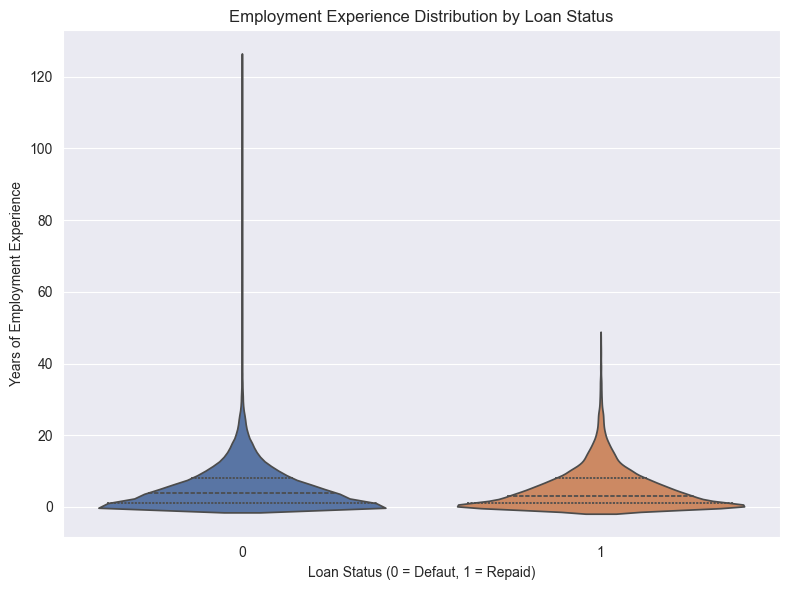

In [20]:
#violin plot employment experince by loan status
plt.figure(figsize=(8, 6))
sns.violinplot(
    x='loan_status',
    y='person_emp_exp',
    hue='loan_status',
    data=loan_df,
    palette={0: '#4C72B0', 1: '#DD8452'},
    dodge=False,
    inner='quartile'
)
plt.legend([], [], frameon=False)
plt.title('Employment Experience Distribution by Loan Status')
plt.xlabel('Loan Status (0 = Defaut, 1 = Repaid)')
plt.ylabel('Years of Employment Experience')
plt.tight_layout()

plt.savefig("graphs/experienceby_status_vplot.png")

plt.show()


### Employment Experience Distribution by Loan Status (Violin Plot)

- **Shape & Density:**  
  - Both violins peak sharply at very low tenures (0–2 years), showing most applicants are early‐career.  
  - The “default” group (blue) has a slightly broader mid‑career ridge (around 5–10 years) compared to the “repaid” group (orange), reflecting more borrowers with stable, longer tenures.

- **Quartile Markers:**  
  - The dotted lines inside each violin mark the 25th, 50th (median), and 75th percentiles—confirming the median for repaid ( approapprox  4 yrs) is higher than defaulted (approx 3 yrs).

- **Long Tails:**  
  - Both distributions have thin tails extending beyond 20 years and up to 120 years.  
  - The default group’s tail is slightly shorter fewer high‑tenure borrowers default.

---

#### Why We Plotted This

- **Visualize Full Distribution:** The violin plot reveals the **density** of experience values (not just summary stats), highlighting where most data points lie.  
- **Compare Groups:** It confirms that **longer tenures** are more prevalent among defaulters, while repaid loans cluster toward lower tenures.  

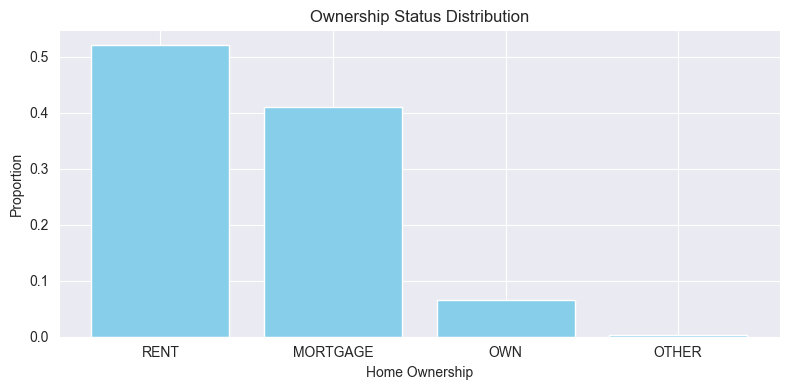

In [21]:
# person_home_ownership bar chart plot

# compute proportion
home_ownership_counts = loan_df['person_home_ownership'].value_counts(normalize=True)

plt.figure(figsize=(8, 4))
plt.bar(home_ownership_counts.index, home_ownership_counts.values, color='skyblue')
plt.title('Ownership Status Distribution')
plt.xlabel('Home Ownership')        
plt.ylabel('Proportion')            
plt.tight_layout()

# save plot
plt.savefig("graphs/ownership_bar.png")
plt.show()


### Home Ownership Status Distribution

- **Renters (RENT):** approximately 52% of applicants rent their home, making it the largest group.  
- **Mortgage Holders (MORTGAGE):**  approximately 41% carry a mortgage, representing the second‑largest segment.  
- **Owners (OWN):** Only about 7% fully own their home, suggesting outright ownership is relatively rare.  
- **Other:** A very small fraction (<1%) fall into “OTHER” .

**Key Insight:**  
Most borrowers are either renting or financing a purchase via mortgage very few own their home outright. This distribution will help us analyze whether home‑ownership status correlates with default risk and guide encoding strategies (e.g., one‑hot vs. target encoding) for our model.  


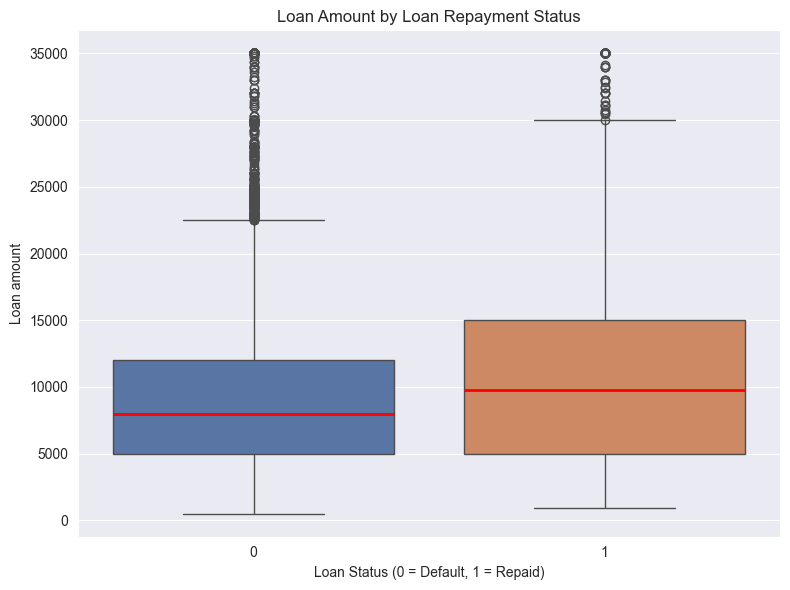

In [22]:
# Employment Experience by Loan Repayment Status

plt.figure(figsize=(8, 6))
sns.boxplot(
    x='loan_status',
    y='loan_amnt',
    hue='loan_status',          
    data=loan_df,
    palette={0: '#4C72B0', 1: '#DD8452'},
    dodge=False,                
    medianprops={'color': 'red', 'linewidth': 2})
plt.legend([], [], frameon=False)  
plt.title('Loan Amount by Loan Repayment Status')
plt.xlabel('Loan Status (0 = Default, 1 = Repaid)')
plt.ylabel('Loan amount')
plt.tight_layout()

#save fig
plt.savefig('graphs/loanamount_byrepayment.png')
plt.show()


### Loan Amount by Loan Repayment Status

- **Median Loan Size:**  
  - **Default (0):** \$8 000  
  - **Repaid (1):** \$9 500  
  The red median lines show that borrowers who default tend to request slightly lower loan amounts.

- **Whiskers & Outliers:**  
  - Both groups have lower whiskers near \$1 000, reflecting a small segment of very small loans.  
  - The repaid group’s upper whisker extends to \$30 000  (vs. \$22 000 for default), and both groups show many outliers at \$35 000, highlighting a cluster of large loans.

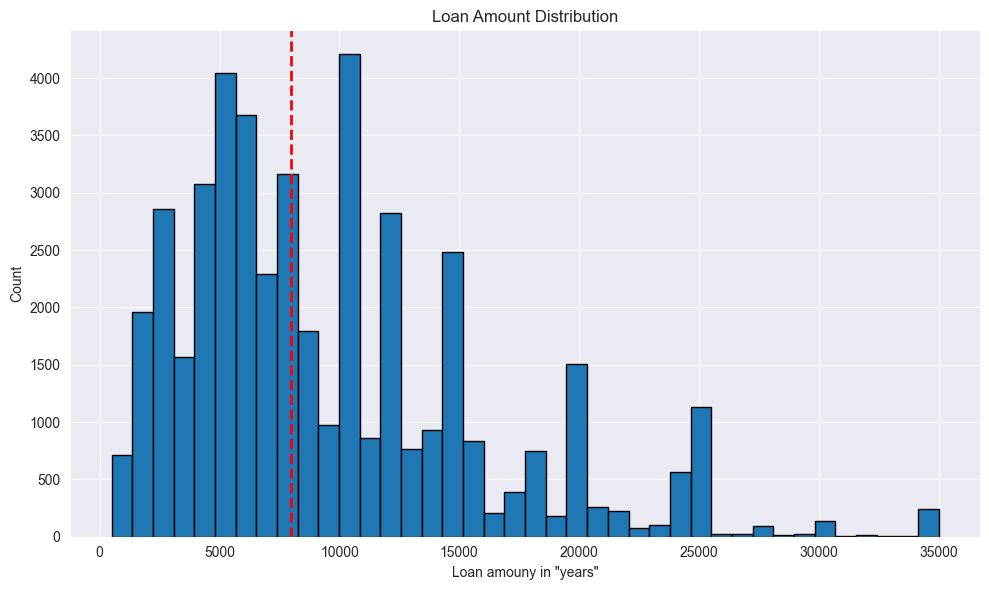

In [20]:
#Loan amount

median_exp = loan_df['loan_amnt'].median()

plt.figure(figsize=(10, 6))
plt.hist(loan_df['loan_amnt'], bins= 40, edgecolor='black')
plt.axvline(median_exp, color='red', linestyle='--', linewidth=2, label=f'Median = ${median_income:,.0f}')
plt.title('Loan Amount Distribution')
plt.xlabel('Loan amouny in "years"')
plt.ylabel('Count')
plt.tight_layout()

#save plot
plt.savefig("graphs/loan_amt.png")
plt.show()


### Loan Amount Distribution

- The histogram shows several common loan‑size clusters around \$5 000, \$10 000, \$15 000, \$20 000, and \$25 000.  
- The red dashed line marks the **median** loan amount at about **\$8 000**, indicating half of loans are smaller than this and half larger.  
- There’s a long right tail out to \$35 000, representing a minority of very large loans.  

**Key Point:** Most borrowers request mid‑range loans \$5k – \$15k.

In [21]:
# Drop age column
loan_df = loan_df.drop(columns = 'person_age')

In [22]:
# max experince years in the data is 120 right. 
# drop experince above 60 Refrence: https://www.guardianlife.com/retirement/average-age

loan_df = loan_df[loan_df['person_emp_exp'] <= 60]

In [23]:
#confirm if experince over 60 was succesfully dropped
loan_df.shape

(44990, 13)

In [24]:
#convert cb_person_cred_hist_length to int
loan_df['cb_person_cred_hist_length'] = loan_df['cb_person_cred_hist_length'].round().astype(int)

In [25]:
#reverse the target variable such that 1 means default and 0 means repaid

loan_df['loan_status'] = loan_df['loan_status'].map({1: 0, 0: 1})

In [26]:
loan_df.head()

,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3,561,No,0
1,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2,504,Yes,1
2,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3,635,No,0
3,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2,675,No,0
4,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4,586,No,0


In [27]:
# Features to log‑transform (to reduce skew)
log_transform_features = ['person_income', 'loan_amnt']
onehot_cols = ['person_gender', 'person_home_ownership', 'loan_intent']
label_cols = ['person_education', 'previous_loan_defaults_on_file']

In [28]:
# Transformers
log_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p))
])

onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

label_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [29]:
preprocessor = ColumnTransformer(transformers=[
    ('log',    log_transformer, log_transform_features),
    ('onehot', onehot_transformer, onehot_cols),
    ('ord',    label_transformer, label_cols)])

In [30]:
feature_cols = log_transform_features + onehot_cols + label_cols